In [0]:
%pip install langchain==0.1.17 langchain-openai==0.1.6 langgraph==0.0.40 databricks-vectorsearch==0.33 mlflow[databricks]==2.12.1 lark==1.1.9 duckduckgo-search==5.3.0 cloudpickle==2.2.1
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for langchain==0.1.17 from https://files.pythonhosted.org/packages/c8/bc/607cd3254800a26b60da9e2ca6b10785e60170db7e85dc3d0328b5ab3a9c/langchain-0.1.17-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-openai==0.1.6 from https://files.pythonhosted.org/packages/1c/ff/d8bf3cacd55cabd85deed923a22a72e0c306a1211584f78a933512c3ef8f/langchain_openai-0.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for langgraph==0.0.40 from https://files.pythonhosted.org/packages/40/ca/4248ee2a1d4aa4e3797fa12e78d8a3a284f490e3ca836176a10eab08ee17/langgraph-0.0.40-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/43.1 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.7 MB/s eta 0:00:00
  Obtaining dependency information for databricks-vectorsearch==0.33 from https://files.pythonho

In [0]:
import json
import os
import operator
from operator import itemgetter
from typing import TypedDict, Annotated, Sequence
from databricks.vector_search.client import VectorSearchClient

from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
from langchain_core.utils.function_calling import convert_to_openai_function, convert_to_openai_tool
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_openai import AzureChatOpenAI
from langchain_community.vectorstores import DatabricksVectorSearch
from langchain_community.embeddings import DatabricksEmbeddings
from langchain_community.chat_models import ChatDatabricks
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from langgraph.graph import StateGraph, END

In [0]:
vs_endpoint_name = "edgar_vs_endpoint"
vs_index_fullname = "llm_hackathon.default.edgar_form_vs_index"
vsc = VectorSearchClient()

embedding_model = DatabricksEmbeddings(endpoint="databricks-bge-large-en")

vs_index = vsc.get_index(
    endpoint_name=vs_endpoint_name,
    index_name=vs_index_fullname
)

vectorstore = DatabricksVectorSearch(
    vs_index, text_column="content", embedding=embedding_model,
    columns=['name', 'tickers', 'exchanges', 'form', 'filing_date', 'industry']
)

chat_model = ChatDatabricks(endpoint="databricks-dbrx-instruct", temperature=0)

[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True to VectorSearchClient().


embedding model is not used in delta-sync index with Databricks-managed embeddings.


In [0]:
metadata_field_info = [
    AttributeInfo(
        name="name",
        description="The name of the company",
        type="string",
    ),
    AttributeInfo(
        name="tickers",
        description="The ticker symbols of the company",
        type="string",
    ),
    AttributeInfo(
        name="exchanges",
        description="The stock exchange where the stock is traded",
        type="string",
    ),
]

document_content_description = "The sec filing of financial and management report of the company."

retriever = SelfQueryRetriever.from_llm(
    chat_model, vectorstore, document_content_description, metadata_field_info, search_kwargs={"k": 10},
)

In [0]:
RAG_TEMPLATE = """\
You are an assistant for financial analyst. You are answering finance question about company's news, stock, financial reports and statements from management (10-K,  10-Q forms) based on the given context. If the question is not related to one of these topics, kindly decline to answer. If the context is empty or you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible.

Question:
{question}

Context:
{context}

Answer:
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

self_query_retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | chat_model
    | StrOutputParser()
)

In [0]:
self_query_retrieval_chain.invoke({'question': "what was alphabet's revenue in 2024 Q1?"})

"Based on the provided context, Alphabet's revenue for Q1 2024 was $80,539 million."

In [0]:
self_query_retrieval_chain.invoke({'question': "what was alphabet's revenue?"})

"Alphabet's revenue for the three months ended March 31, 2023 was $69,787 million, and for the three months ended March 31, 2024 was $80,539 million."

In [0]:
self_query_retrieval_chain.invoke({'question': "what is alphabet's outlook of the future?"})

"Based on the provided context, Alphabet's outlook for the future seems positive. They have initiated a cash dividend program and declared a cash dividend of $0.20 per share. The company has also authorized the repurchase of up to an additional $70.0 billion of its Class A and Class C shares. In terms of financial results, Alphabet reported revenues of $70.4 billion for the three months ended March 31, 2024, an increase from the $61.9 billion reported for the same period in 2023. The company's operating cash flow was $28.8 billion for the three months ended March 31, 2024. However, it is important to note that these financial results are subject to various factors such as changes in foreign currency exchange rates, general economic conditions, and new product and service launches."

In [0]:
self_query_retrieval_chain.invoke({'question': "how are microsoft's financial numbers?"})

"Microsoft's financial numbers are strong, with revenue increasing by 11% in the Windows segment, driven by growth in Windows Commercial and Windows OEM. Gaming revenue increased by 51%, driven by growth in Xbox content and services. Search and news advertising revenue increased by 3%. Devices revenue decreased by 17%. Operating income increased by 16%."

In [0]:
self_query_retrieval_chain.invoke({'question': "which challenges is meta facing?"})

"Meta Platforms, Inc. is facing several challenges, including increased competition, regulatory scrutiny, and difficulties in measuring key metrics. The company is also investing in the metaverse, which may not be successful and could divert resources from other areas of the business. Additionally, Meta's user growth and engagement have slowed in certain demographics, and the company is subject to data privacy and security risks."

In [0]:
self_query_retrieval_chain.invoke({'question': "what was amazon's revenue?"})

AIMessage(content="I don't have the specific context or real-time data access to provide the current revenue of Amazon. I would recommend checking their latest financial reports or statements from management for the most accurate information.", response_metadata={'prompt_tokens': 335, 'completion_tokens': 38, 'total_tokens': 373}, id='run-7504fdb4-863f-4ca0-9484-a42274a37ccf-0')

In [0]:
os.environ["AZURE_OPENAI_ENDPOINT"] = dbutils.secrets.get(scope="development", key="azure_openai_endpoint")
os.environ["AZURE_OPENAI_API_KEY"] = dbutils.secrets.get(scope="development", key="azure_openai_api_key")

search_tool = DuckDuckGoSearchRun()
tools = [search_tool]
tool_executor = ToolExecutor(tools)
functions = [convert_to_openai_function(t) for t in tools]

model = AzureChatOpenAI(
    api_version=dbutils.secrets.get(scope="development", key="azure_openai_chat_deployment_version"),
    azure_deployment=dbutils.secrets.get(scope="development", key="azure_openai_chat_deployment_name"),
    temperature=0,
)
model = model.bind_functions(functions)

In [0]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

def call_tool(state):
  last_message = state["messages"][-1]

  action = ToolInvocation(
      tool=last_message.additional_kwargs["function_call"]["name"],
      tool_input=json.loads(
          last_message.additional_kwargs["function_call"]["arguments"]
      )
  )

  response = tool_executor.invoke(action)

  function_message = FunctionMessage(content=str(response), name=action.tool)

  return {"messages" : [function_message]}

def should_continue(state):
  last_message = state["messages"][-1]

  if "function_call" not in last_message.additional_kwargs:
    return "end"

  return "continue"

In [0]:
self_query_retrieval_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | rag_prompt
    | chat_model
)

In [0]:
def convert_state_to_query(state_object):
  return {"question" : state_object["messages"][-1].content}

def convert_response_to_state(response):
  return {"messages" : [response]}

langgraph_node_rag_chain = convert_state_to_query | self_query_retrieval_chain | convert_response_to_state

In [0]:
rag_agent = StateGraph(AgentState)

rag_agent.add_node("agent", call_model)
rag_agent.add_node("action", call_tool)
rag_agent.add_node("first_action", langgraph_node_rag_chain)
rag_agent.set_entry_point("first_action")

In [0]:
def is_fully_answered(state):

    ### Extract the question and response from our RAG pipeline
    question = state["messages"][0].content
    answer = state["messages"][-1].content

    ### Create a Pydantic model to capture our LLMs response
    class answered(BaseModel):
        binary_score: str = Field(description="Fully answered: 'yes' or 'no'")

    ### Create and bind our tool to our model
    answered_tool = convert_to_openai_tool(answered)
    model = AzureChatOpenAI(
        api_version=dbutils.secrets.get(scope="development", key="azure_openai_chat_deployment_version"),
        azure_deployment=dbutils.secrets.get(scope="development", key="azure_openai_chat_deployment_name"),
        temperature=0,
    )
    model = model.bind(
        tools=[answered_tool],
        tool_choice={"type" : "function", "function" : {"name" : "answered"}}
    )

    ### We'll want to parse the output into a usable format
    parser_tool = PydanticToolsParser(tools=[answered])

    prompt = PromptTemplate(
        template="""You will determine if the question is fully answered by the response.\n
        Question:
        {question}

        Response:
        {answer}

        You will respond with either 'yes' or 'no'.""",
        input_variables=["question", "answer"])

    ### Classic LCEL chain!
    fully_answered_chain = prompt | model | parser_tool

    response = fully_answered_chain.invoke({"question" : question, "answer" : answer})

    if response[0].binary_score == "no":
        return "continue"

    return "end"

In [0]:
rag_agent.add_conditional_edges(
    "first_action",
    is_fully_answered,
    {
        "continue" : "agent",
        "end" : END
    }
)

rag_agent.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : END
    }
)

rag_agent.add_edge("action", "agent")
rag_agent_app = rag_agent.compile()

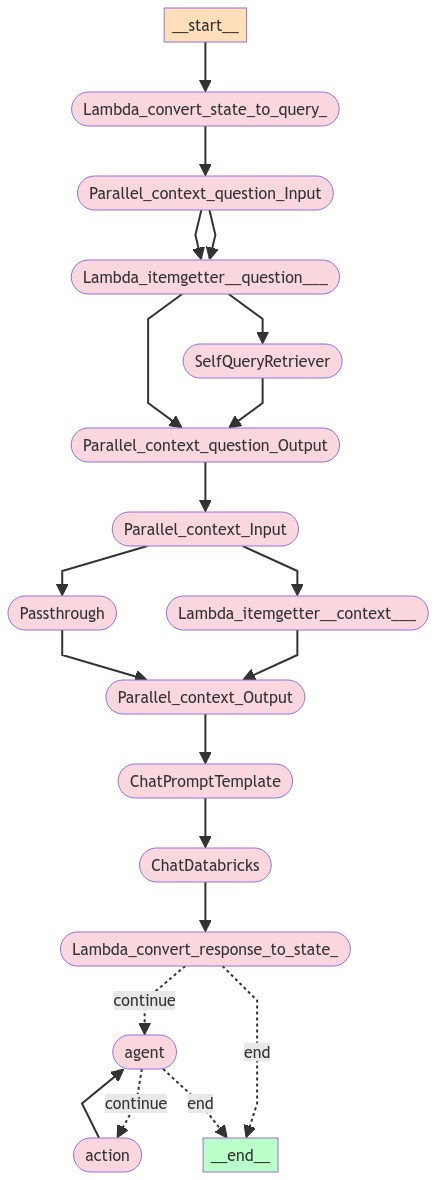

In [0]:
from IPython.display import Image

display(Image(rag_agent_app.get_graph(xray=True).draw_mermaid_png()))

In [0]:
question = "what was alphabet's revenue?"

inputs = {"messages" : [HumanMessage(content=question)]}

for output in rag_agent_app.stream(inputs):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        for message in value['messages']:
            print(message.content)
    print("\n---\n")

Output from node 'first_action':
---
Alphabet's revenue for the three months ended March 31, 2023 was $69,787 million, and for the three months ended March 31, 2024 was $80,539 million.

---



In [0]:
question = "what was amazon's revenue?"

inputs = {"messages" : [HumanMessage(content=question)]}

for output in rag_agent_app.stream(inputs):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        for message in value['messages']:
            print(message.content)
    print("\n---\n")

Output from node 'first_action':
---
I don't have the specific context or real-time data access to provide the current revenue of Amazon. I would recommend checking their latest financial reports or statements from management for the most accurate information.

---

Output from node 'agent':
---


---

Output from node 'action':
---
Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results for its fourth quarter ended December 31, 2023. Fourth Quarter 2023 Net sales increased 14% to $170.0 billion in the fourth quarter, compared with $149.2 billion in fourth quarter 2022. Excluding the $1.3 billion favorable impact from year-over-year changes in foreign exchange rates throughout the quarter, net sales increased 13 ... Amazon's first quarter revenue: Q1 2024: $143.3 billion Q1 2023: $127.4 billion Q1 2022: $116.4 billion ... fees which could help Amazon drive substantial revenue. Amazon has been expanding ... In this article: AMZN. Amazon.com Inc ( NASDAQ:AMZN) reports a 13% inc

In [0]:
host = "https://" + spark.conf.get("spark.databricks.workspaceUrl")
os.environ['DATABRICKS_TOKEN'] = dbutils.secrets.get("development", "rag_sp_token")

def get_retriever(persist_dir: str = None):
    os.environ["DATABRICKS_HOST"] = host
    #Get the vector search index
    vsc = VectorSearchClient(workspace_url=host, personal_access_token=os.environ["DATABRICKS_TOKEN"])
    vs_index = vsc.get_index(
        endpoint_name=vs_endpoint_name,
        index_name=vs_index_fullname
    )

    # Create the self-query retriever
    vectorstore = DatabricksVectorSearch(
        vs_index, text_column="content", embedding=embedding_model,
        columns=['name', 'tickers', 'exchanges', 'form', 'filing_date', 'industry']
    )
    chat_model = ChatDatabricks(endpoint="databricks-dbrx-instruct", temperature=0)
    retriever = SelfQueryRetriever.from_llm(
        chat_model, vectorstore, document_content_description, metadata_field_info, search_kwargs={"k" : 10},
    )

    return retriever

In [0]:
import cloudpickle
import langchain
import langgraph
import mlflow
import duckduckgo_search
from mlflow.models import infer_signature

mlflow.set_registry_uri("databricks-uc")

model_name = "llm_hackathon.default.self_query_rag_model"
inputs = {'question': "what was alphabet's revenue?"}
self_query_retrieval_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | chat_model
    | StrOutputParser()
)

In [0]:
with mlflow.start_run(run_name="self_query_rag") as run:
    #Get our model signature from input/output
    output = self_query_retrieval_chain.invoke(inputs)
    signature = infer_signature(inputs, output)

    model_info = mlflow.langchain.log_model(
        self_query_retrieval_chain,
        loader_fn=get_retriever,
        artifact_path="chain",
        registered_model_name=model_name,
        pip_requirements=[
            "mlflow==" + mlflow.__version__,
            "langchain==" + langchain.__version__,
            "duckduckgo-search",
            "databricks-vectorsearch",
            "lark",
            "pydantic==2.5.2 --no-binary pydantic",
            "cloudpickle=="+ cloudpickle.__version__
        ],
        input_example=inputs,
        signature=signature,
        example_no_conversion=True,
    )